In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


## Eval of Retraining

In [3]:
max_knn = 100

In [4]:
# Function: compare average closest_cross_entropy for three similarity metrics
# Usage: call compare_avg_closest_cross_entropy(cross_results_l1, cross_results_l2, cross_results_cosine, key='closest_cross_entropy', max_k=max_knn)
import numpy as np
import matplotlib.pyplot as plt

def compare_avg_closest_cross_entropy(cross_l1, cross_l2, cross_cosine, key='closest_cross_entropy', max_k=None, title=None):
    """Compute the mean across samples for the given key (default 'closest_cross_entropy')
    for three cross_results objects and plot them together. Also prints the three
    mean series side-by-side for easy text comparison.

    Supports inputs where the key maps to:
    - a list of arrays (n_samples x n_k)
    - a numpy array (n_samples x n_k or n_k)
    - the cross_results itself may be a dict containing the key
    """
    def extract_mean(x):
        # If caller passed a dict-like object, fetch the key
        if isinstance(x, dict):
            if key not in x:
                raise KeyError(f"Key '{key}' not found in provided cross_results dict")
            v = x[key]
        else:
            v = x
        arr = np.array(v)
        if arr.ndim == 1:
            return arr
        # mean across samples (axis 0 is sample axis if shape is (n_samples, n_k))
        return arr.mean(axis=0)

    m1 = extract_mean(cross_l1)
    m2 = extract_mean(cross_l2)
    m3 = extract_mean(cross_cosine)

    # Determine length and trim to max_k if requested
    n = max(len(m1), len(m2), len(m3))
    if max_k is not None:
        n = min(n, int(max_k))
    m1 = np.asarray(m1)[:n]
    m2 = np.asarray(m2)[:n]
    m3 = np.asarray(m3)[:n]

    ks = np.arange(1, n + 1)

    plt.figure(figsize=(8, 4.5))
    plt.plot(ks, m1, label='L1', marker='o', markersize=3)
    plt.plot(ks, m2, label='L2', marker='s', markersize=3)
    plt.plot(ks, m3, label='Cosine', marker='^', markersize=3)
    plt.xlabel('k (neighbors)')
    plt.ylabel(key)
    plt.title(title or f'Average {key}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print side-by-side (tab-separated) with 4-decimals
    from itertools import zip_longest
    def fmt(a):
        return [f"{float(x):.4f}" for x in a]

    rows = zip_longest(fmt(m1), fmt(m2), fmt(m3), fillvalue='')
    print('\t'.join(['L1', 'L2', 'Cosine']))
    for r in rows:
        print('\t'.join(r))

    return {'ks': ks, 'l1': m1, 'l2': m2, 'cosine': m3}


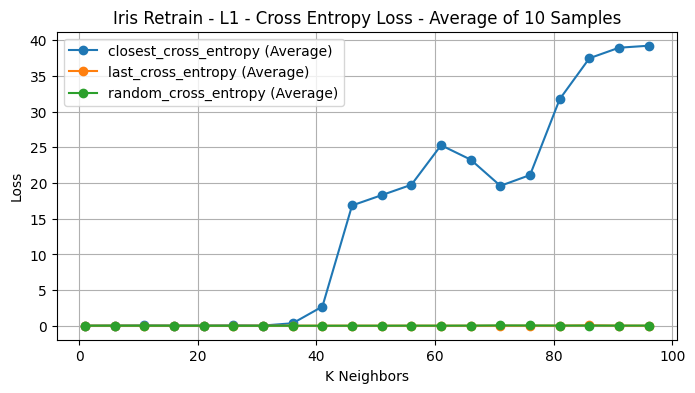

In [5]:
with open('retrain_data/l1/random_indices_50.pkl', 'rb') as f:
    random_indices_l1 = pickle.load(f)

with open('retrain_data/l1/cross_results_50.pkl', 'rb') as f:
    cross_results_l1 = pickle.load(f)

with open('retrain_data/l1/knn_distances_50.pkl', 'rb') as f:
    knn_distances_l1 = pickle.load(f)

visualize_results(cross_results_l1, random_indices_l1, average=True, normalize=False, title=f"Iris Retrain - L1 - Cross Entropy Loss - Average of {10} Samples", max_knn=max_knn)
#plot_knn_distance_stats(knn_distances_l1, subset='closest',k=100, title="KNN Distance Statistics - L1 Similarity")

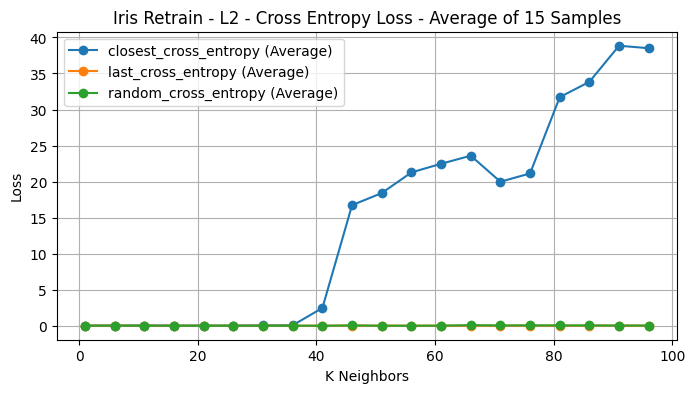

In [6]:
with open('retrain_data/l2/random_indices_50.pkl', 'rb') as f:
    random_indices_l2 = pickle.load(f)

with open('retrain_data/l2/cross_results_50.pkl', 'rb') as f:
    cross_results_l2 = pickle.load(f)

with open('retrain_data/l2/knn_distances_50.pkl', 'rb') as f:
    knn_distances_l2 = pickle.load(f)

visualize_results(cross_results_l2, random_indices_l2, average=True, normalize=False, title=f"Iris Retrain - L2 - Cross Entropy Loss - Average of {len(random_indices_l2)} Samples", max_knn=max_knn)
#plot_knn_distance_stats(knn_distances_l2, subset='closest',k=96, title="KNN Distance Statistics - L2 Similarity")

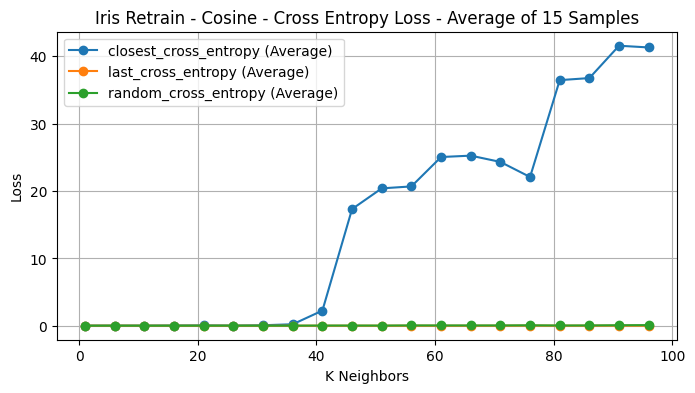

In [7]:
with open('retrain_data/cosine/random_indices_50.pkl', 'rb') as f:
    random_indices_cosine = pickle.load(f)

with open('retrain_data/cosine/cross_results_50.pkl', 'rb') as f:
    cross_results_cosine = pickle.load(f)

with open('retrain_data/cosine/knn_distances_50.pkl', 'rb') as f:
    knn_distances_cosine = pickle.load(f)

visualize_results(cross_results_cosine, random_indices_cosine, average=True, normalize=False, title=f"Iris Retrain - Cosine - Cross Entropy Loss - Average of {len(random_indices_cosine)} Samples", max_knn=max_knn)
#plot_knn_distance_stats(knn_distances_cosine, subset='closest',k=96, title="KNN Distance Statistics - Retrain - Cosine Similarity")

In [8]:
# res = compare_avg_closest_cross_entropy(
#     cross_results_l1, cross_results_l2, cross_results_cosine,
#     key='closest_cross_entropy', max_k=max_knn,
#     title=f'Iris: Average closest_cross_entropy (first {max_knn} neighbors)'
# )

{1: 0.012339445127023889, 6: 0.028267437190773136, 11: 0.04458382929201813, 16: 0.033126508951924434, 21: 0.0325642259463469, 26: 0.05141183254830442, 31: 0.030385528885805493, 36: 0.355576170606461, 41: 2.694422978232615, 46: 16.859974280248085, 51: 18.307341401527324, 56: 19.761543612678846, 61: 25.302940225601198, 66: 23.27810471057892, 71: 19.611066778500874, 76: 21.124670673906802, 81: 31.761054706573486, 86: 37.49167442321777, 91: 38.9689759572347, 96: 39.24644788106283}
{1: 0.012342385167842924, 6: 0.029386540599917528, 11: 0.03225319004509781, 16: 0.015421928259699295, 21: 0.020144487049147605, 26: 0.02132331968459719, 31: 0.049279651961387574, 36: 0.07570245431609995, 41: 2.4653590861087045, 46: 16.731747010101873, 51: 18.405701518058777, 56: 21.27253459294637, 61: 22.470383739471437, 66: 23.59374100367228, 71: 19.98348061243693, 76: 21.13019995043675, 81: 31.711932977040608, 86: 33.84108721415202, 91: 38.84844741821289, 96: 38.504289881388345}
{1: 0.020316762314269, 6: 0.0208

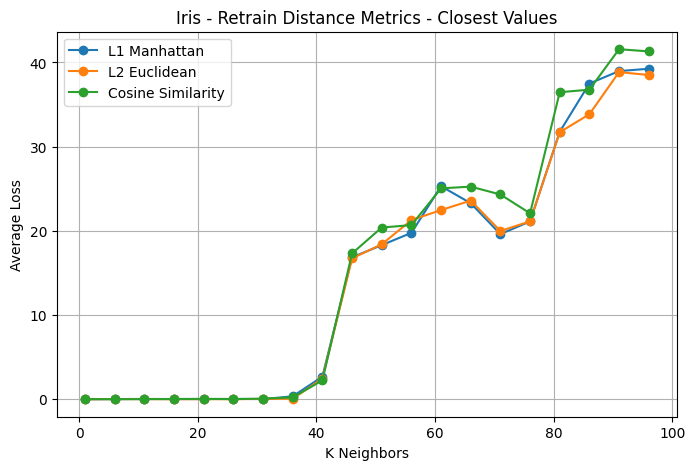

In [9]:
retrain_averages_l1 = {k: sum(v) / len(v) for k, v in cross_results_l1['closest_cross_entropy'].items()}
retrain_averages_l2 = {k: sum(v) / len(v) for k, v in cross_results_l2['closest_cross_entropy'].items()}
retrain_averages_cosine = {k: sum(v) / len(v) for k, v in cross_results_cosine['closest_cross_entropy'].items()}

print(retrain_averages_l1)
print(retrain_averages_l2)
print(retrain_averages_cosine)

datasets = [
    ("L1 Manhattan", retrain_averages_l1),
    ("L2 Euclidean", retrain_averages_l2),
    ("Cosine Similarity", retrain_averages_cosine)
]

plt.figure(figsize=(8,5))

for name, d in datasets:
    # Sort by keys to ensure correct order on x-axis
    x = sorted(d.keys())
    y = [d[k] for k in x]
    plt.plot(x, y, marker="o", label=name)

plt.title("Iris - Retrain Distance Metrics - Closest Values")
plt.xlabel("K Neighbors")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()

1: min=8.75989  max=41.2616  avg=16.5192
10: min=14.9304  max=65.8292  avg=35.9999
20: min=25.4966  max=105.239  avg=56.586
30: min=30.6456  max=266.463  avg=109.043
40: min=49.7612  max=339.495  avg=160.979
50: min=86.5234  max=372.069  avg=215.332
60: min=100.898  max=465.05  avg=257.278
70: min=117.27  max=465.05  avg=274.915
80: min=189.243  max=465.05  avg=290.635
90: min=200.239  max=465.05  avg=299.181
100: min=209.164  max=465.05  avg=307.95


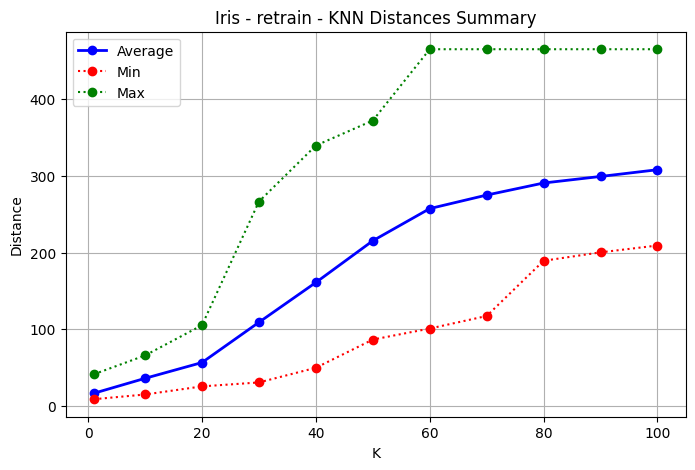

In [20]:
import statistics as stats

closest = knn_distances_l1['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line with dots
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2, marker="o")

# Plot min and max as dotted lines with dots
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted", marker="o")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted", marker="o")

plt.title("Iris - retrain - KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()

## Eval of Continue Training

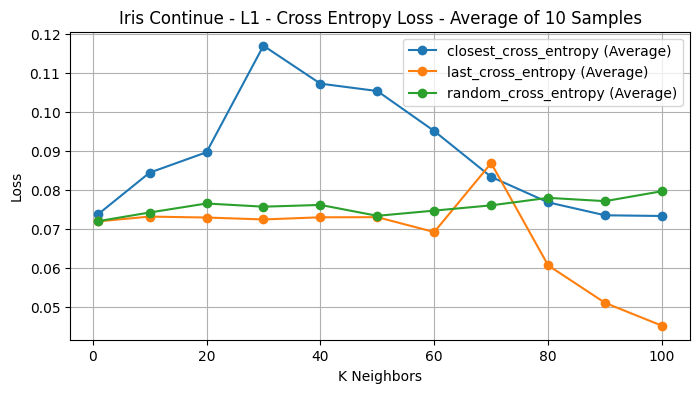

In [11]:
with open('continue_data/l1/random_indices_50.pkl', 'rb') as f:
    con_random_indices_l1 = pickle.load(f)

with open('continue_data/l1/cross_results_50.pkl', 'rb') as f:
    con_cross_results_l1 = pickle.load(f)

with open('continue_data/l1/knn_distances_50.pkl', 'rb') as f:
    con_knn_distances_l1 = pickle.load(f)

visualize_results(con_cross_results_l1, con_random_indices_l1, average=True, normalize=False, title=f"Iris Continue - L1 - Cross Entropy Loss - Average of {len(con_random_indices_l1)} Samples", max_knn=max_knn)
#plot_knn_distance_stats(con_knn_distances_l1, subset='closest',k=max_knn, title="KNN Distance Statistics - Continue - L1")

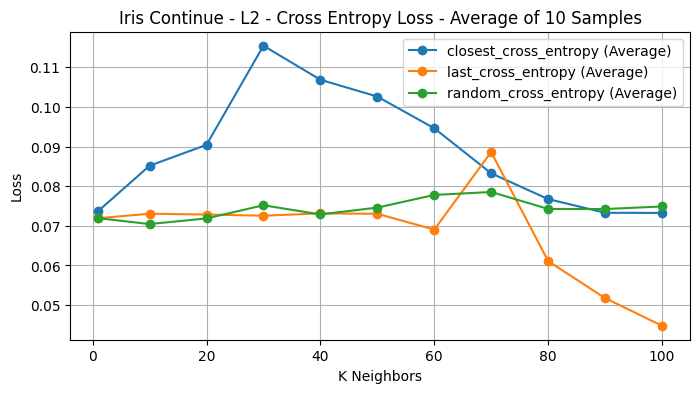

In [12]:
with open('continue_data/l2/random_indices_50.pkl', 'rb') as f:
    con_random_indices_l2 = pickle.load(f)

with open('continue_data/l2/cross_results_50.pkl', 'rb') as f:
    con_cross_results_l2 = pickle.load(f)

with open('continue_data/l2/knn_distances_50.pkl', 'rb') as f:
    con_knn_distances_l2 = pickle.load(f)

visualize_results(con_cross_results_l2, con_random_indices_l2, average=True, normalize=False, title=f"Iris Continue - L2 - Cross Entropy Loss - Average of {len(con_random_indices_l2)} Samples", max_knn=max_knn)
#plot_knn_distance_stats(con_knn_distances_l2, subset='closest',k=max_knn, title="KNN Distance Statistics - Continue - L2")

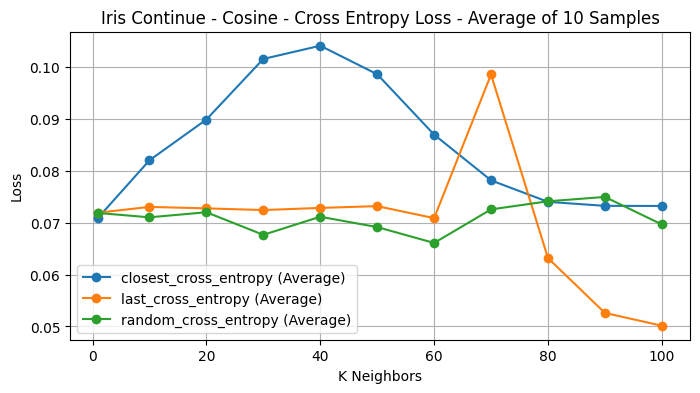

In [13]:
with open('continue_data/cosine/random_indices_50.pkl', 'rb') as f:
    con_random_indices_cosine = pickle.load(f)

with open('continue_data/cosine/cross_results_50.pkl', 'rb') as f:
    con_cross_results_cosine = pickle.load(f)

with open('continue_data/cosine/knn_distances_50.pkl', 'rb') as f:
    con_knn_distances_cosine = pickle.load(f)

visualize_results(con_cross_results_cosine, con_random_indices_cosine, average=True, normalize=False, title=f"Iris Continue - Cosine - Cross Entropy Loss - Average of {len(con_random_indices_cosine)} Samples", max_knn=max_knn)
#plot_knn_distance_stats(con_knn_distances_cosine, subset='closest',k=max_knn, title="KNN Distance Statistics - Continue - Cosine Similarity")

In [14]:
print(con_cross_results_l1['closest_cross_entropy'])
print(con_cross_results_l2['closest_cross_entropy'])
print(con_cross_results_cosine['closest_cross_entropy'])

{1: [0.06327982246875763, 0.054402947425842285, 0.047215770930051804, 0.24867290258407593, 0.1465344876050949, 0.02800101228058338, 0.07642924040555954, 0.030318301171064377, 0.00040546778473071754, 0.0422591008245945], 10: [0.059467874467372894, 0.06295940279960632, 0.055608637630939484, 0.29294875264167786, 0.18153300881385803, 0.028453567996621132, 0.07995250821113586, 0.03279971331357956, 0.00041154498467221856, 0.04940289258956909], 20: [0.048618100583553314, 0.06739718466997147, 0.06428864598274231, 0.2905111312866211, 0.19472290575504303, 0.03271791711449623, 0.09958920627832413, 0.0371493361890316, 0.00041559641249477863, 0.06052128225564957], 30: [0.04070888087153435, 0.09049852192401886, 0.09450001269578934, 0.3679533302783966, 0.2706300616264343, 0.04275208339095116, 0.12513484060764313, 0.052111443132162094, 0.00042572495294734836, 0.08418779820203781], 40: [0.04893293231725693, 0.08424489200115204, 0.08007080107927322, 0.359066367149353, 0.2133842408657074, 0.0433739349246

{1: 0.07375190534803551, 10: 0.08435379034490324, 20: 0.08959313065279276, 30: 0.1168902697681915, 40: 0.10716986295883543, 50: 0.10527955475554336, 60: 0.09502117780211847, 70: 0.08327755343343597, 80: 0.0767571956384927, 90: 0.07343985933403019, 100: 0.0732577011687681}
{1: 0.07375190534803551, 10: 0.08516842080862261, 20: 0.09043969579506665, 30: 0.11546629626245704, 40: 0.106877001124667, 50: 0.10263315434858669, 60: 0.09462647323671262, 70: 0.08325599443342072, 80: 0.07675011422252283, 90: 0.07328384379216005, 100: 0.07324821230431552}
{1: 0.0710007178975502, 10: 0.08205115002638194, 20: 0.0899202990840422, 30: 0.10160533751477488, 40: 0.10415735421702266, 50: 0.09865771155164112, 60: 0.08700810445880051, 70: 0.07818553754477761, 80: 0.07403880658675917, 90: 0.07326729457417969, 100: 0.07324599466228392}


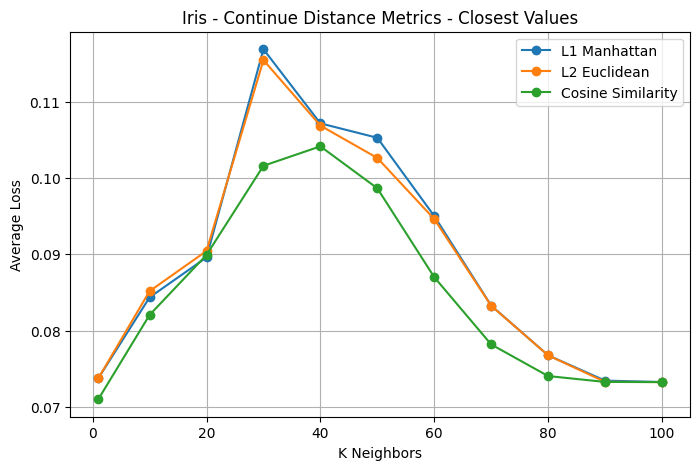

In [15]:
continue_averages_l1 = {k: sum(v) / len(v) for k, v in con_cross_results_l1['closest_cross_entropy'].items()}
continue_averages_l2 = {k: sum(v) / len(v) for k, v in con_cross_results_l2['closest_cross_entropy'].items()}
continue_averages_cosine = {k: sum(v) / len(v) for k, v in con_cross_results_cosine['closest_cross_entropy'].items()}

print(continue_averages_l1)
print(continue_averages_l2)
print(continue_averages_cosine)

datasets = [
    ("L1 Manhattan", continue_averages_l1),
    ("L2 Euclidean", continue_averages_l2),
    ("Cosine Similarity", continue_averages_cosine)
]

plt.figure(figsize=(8,5))

for name, d in datasets:
    # Sort by keys to ensure correct order on x-axis
    x = sorted(d.keys())
    y = [d[k] for k in x]
    plt.plot(x, y, marker="o", label=name)

plt.title("Iris - Continue Distance Metrics - Closest Values")
plt.xlabel("K Neighbors")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()

1: min=8.63765  max=40.6672  avg=16.254
10: min=15.6585  max=62.4371  avg=33.0014
20: min=25.4079  max=97.5517  avg=50.7909
30: min=32.2052  max=204.153  avg=86.8946
40: min=47.7785  max=270.178  avg=129.592
50: min=65.0361  max=286.815  avg=175.686
60: min=75.8061  max=372.257  avg=209.953
70: min=106.187  max=373.076  avg=225.289
80: min=161.835  max=374.204  avg=237.998
90: min=168.835  max=372.803  avg=243.277
100: min=173.522  max=372.635  avg=249.669


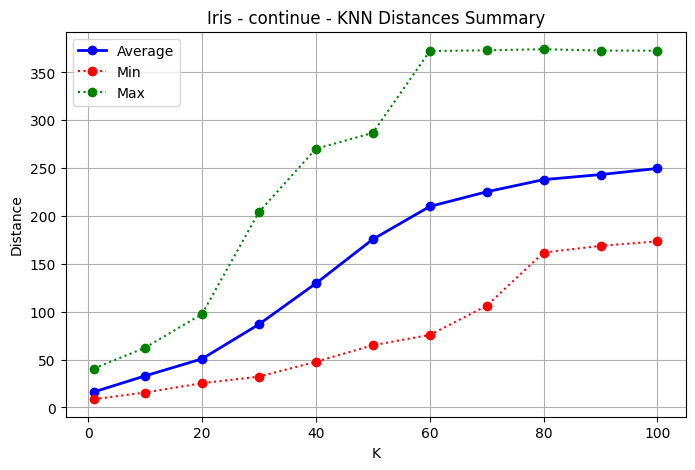

In [19]:
import statistics as stats

closest = con_knn_distances_l1['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x_con = sorted(summary.keys())
y_min_con = [summary[k]["min"] for k in x_con]
y_max_con = [summary[k]["max"] for k in x_con]
y_avg_con = [summary[k]["avg"] for k in x_con]

plt.figure(figsize=(8,5))

# Plot avg as solid line with dots
plt.plot(x_con, y_avg_con, label="Average", color="blue", linewidth=2, marker="o")

# Plot min and max as dotted lines with dots
plt.plot(x_con, y_min_con, label="Min", color="red", linestyle="dotted", marker="o")
plt.plot(x_con, y_max_con, label="Max", color="green", linestyle="dotted", marker="o")

plt.title("Iris - continue - KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()

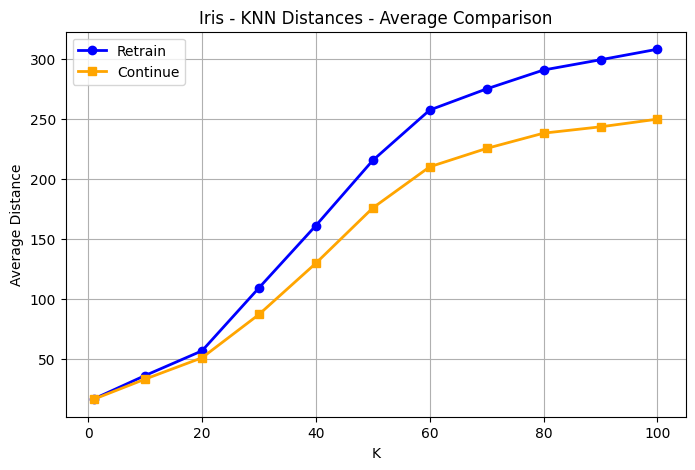

In [18]:
import statistics as stats
import matplotlib.pyplot as plt

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

def summarize(closest):
    summary = {}
    for k, v in closest.items():
        vals = flatten_one_level(v)
        if vals:
            summary[k] = stats.fmean(vals)
    return summary

def xy_from_summary(summary):
    x = sorted(summary.keys())
    y_avg = [summary[k] for k in x]
    return x, y_avg

# --- your two datasets ---
closest_a = knn_distances_l1['closest_distances']
closest_b = con_knn_distances_l1['closest_distances']

summary_a = summarize(closest_a)
summary_b = summarize(closest_b)

x_a, yavg_a = xy_from_summary(summary_a)
x_b, yavg_b = xy_from_summary(summary_b)

plt.figure(figsize=(8,5))

plt.plot(x_a, yavg_a, label="Retrain", color="blue", linewidth=2, marker="o")
plt.plot(x_b, yavg_b, label="Continue", color="orange", linewidth=2, marker="s")

plt.title("Iris - KNN Distances - Average Comparison")
plt.xlabel("K")
plt.ylabel("Average Distance")
plt.legend()
plt.grid(True)
plt.show()
